In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "../fitting/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries
from MaStarChecks.plotting.styles import *

PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.2")

LABELS = ("GSL", "MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r""]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"], units.values())}

In [2]:
def W_ij(y0, y_grid, sigmas):
    """Returns the weights in the parameter space to interpolate in the given point"""
    grid_min = y_grid.min(axis=0)
    grid_max = y_grid.max(axis=0)
    for j in range(len(grid_min)):
        if not grid_min[j]<y0[j]<grid_max[j]: raise ValueError(f"parameter {j}, {y0[j]}, is not within the grid: [{grid_min[j]},{grid_max[j]}]")
    
    in_grid = (y_grid==y0).all(axis=1)
    if in_grid.any():
        weights = np.zeros(y_grid.shape[0])
        weights[in_grid] = 1
        return weights

    weights = np.exp(-((y_grid-y0[None])/sigmas[None])**2).prod(axis=1)
    return weights / weights.sum()

def vaz_interpolator(y0, y_grid, sigmas, spectra_grid):
    """Returns the interpolated stellar spectrum given a parameter grid and a new point using Vazdekis+ method"""
    weights = W_ij(y0, y_grid, sigmas)

    new_spectrum = (spectra_grid*weights[:,None]).sum(axis=0)
    new_y = (y_grid*weights[:,None]).sum(axis=0)
    return new_spectrum, new_y

In [3]:
spectra, catalogues = load_libraries(labels=LABELS, spectra_types=["FLUX", "ERROR"], libraries_path=PROCESSED_PATH, use_cache=True, cache_path=CACHE_PATH)

catalogue = pd.DataFrame()
for label, c in catalogues.items():
    c["LIBRARY"] = label
    catalogue = catalogue.append(c, ignore_index=True)

catalogue.rename(columns=cols, inplace=True)
fluxes = pd.concat([s["FLUX"] for label, s in spectra.items()], axis="index", ignore_index=True)
errors = pd.concat([s["ERROR"] for label, s in spectra.items()], axis="index", ignore_index=True)

catalogue[cols.get("TEFF")] = np.log10(catalogue[cols.get("TEFF")])

fluxes_mastar = fluxes.loc[catalogue.LIBRARY=="MaStar"].reset_index(drop=True)
errors_mastar = errors.copy().reset_index(drop=True)
fluxes_gsl = fluxes.loc[catalogue.LIBRARY=="GSL"].reset_index(drop=True)

catalogue_mastar = catalogue.loc[catalogue.LIBRARY=="MaStar"].reset_index(drop=True)
catalogue_gsl = catalogue.loc[catalogue.LIBRARY=="GSL"].reset_index(drop=True)

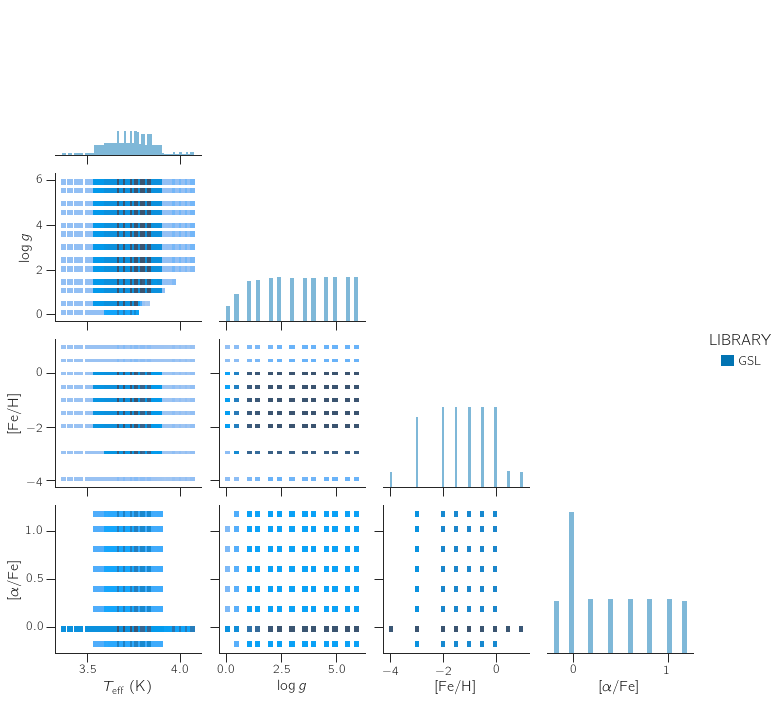

In [4]:
catalogue_comb = pd.concat((catalogue_gsl,catalogue_mastar))

sns.pairplot(catalogue_gsl.filter(list(cols.values())+["LIBRARY"]), corner=True, hue="LIBRARY", kind="hist")

In [9]:
from MaStarChecks.constants import WAVELENGTH_NORM


y_gsl = catalogue_gsl.filter(items=cols.values())
y_y19 = catalogue_mastar.filter(items=cols.values()).dropna()
fluxes_y19 = fluxes_mastar.loc[y_y19.index]
errors_y19 = errors_mastar.loc[y_y19.index]

fluxes_grid = fluxes_gsl.values*catalogue_gsl.FNORM.values[:, None]

# the typical uncertainty in the parameters is half the minimum distance between two contiguous points
sigma_y = y_gsl.agg(lambda s: np.diff(s.drop_duplicates().sort_values()).min(), axis="index").values

new_fluxes = np.zeros_like(fluxes_y19)
new_points = np.zeros_like(y_y19)
for idx in tqdm(range(len(y_y19)), total=len(y_y19), desc="interpolating GSL", unit="spectrum", ascii=True):
    try:
        new_fluxes[idx], new_points[idx] = vaz_interpolator(y0=y_y19.iloc[idx].values, y_grid=y_gsl.values, sigmas=sigma_y, spectra_grid=fluxes_grid)
    except ValueError as err:
        # tqdm.write(f"{err.args[0]}")
        continue

wl_norm = (fluxes_gsl.columns>=WAVELENGTH_NORM[0])&(fluxes_gsl.columns<=WAVELENGTH_NORM[1])
fl_norm = np.median(new_fluxes[:, wl_norm], axis=1)

new_fluxes = np.divide(new_fluxes, fl_norm[:, None], where=fl_norm[:, None]!=0, out=np.zeros_like(new_fluxes))

int_errors = np.divide(new_fluxes-fluxes_y19, fluxes_y19, where=fluxes_y19!=0, out=np.ones_like(new_fluxes)) * 100
y_err = np.divide(new_points-y_y19.values, y_y19.values, where=y_y19.values!=0, out=np.ones_like(y_y19)) * 100

interpolating GSL: 100%|##########| 2578/2578 [31:26<00:00,  1.37spectrum/s]


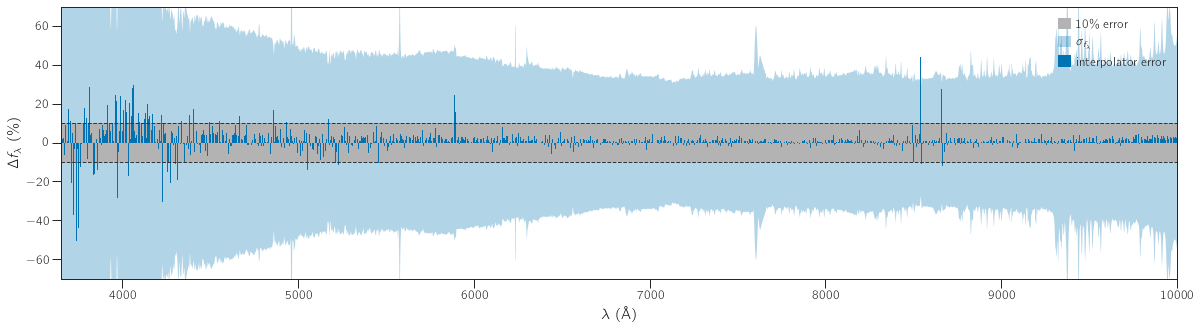

In [55]:
success_mask = (new_fluxes!=0).all(axis=1)

success_errors = int_errors[success_mask]
success_central_error = np.median(success_errors, axis=0)
propagated_sigma = np.sqrt((errors_y19**2).sum(axis=0))*100

plt.figure(figsize=(20,5))
plt.fill_between(fluxes_y19.columns, +propagated_sigma, -propagated_sigma, alpha=0.3, fc="b", label=r"$\sigma_{f_\lambda}$")
plt.axhspan(-10, +10, lw=0, fc="0.7", alpha=1, label=r"$10\%$ error")
plt.bar(fluxes_y19.columns, success_central_error, label=r"interpolator error")
plt.xlim(fluxes_y19.columns[0], fluxes_y19.columns[-1])
plt.ylim(-70, +70)
plt.axhline(-10, ls="--", lw=1, color="0.2")
plt.axhline(+10, ls="--", lw=1, color="0.2")
plt.xlabel(r"$\lambda$ (\AA)")
plt.ylabel(r"$\Delta f_{\lambda}$ (\%)")
plt.legend(loc=1)

In [50]:
from astropy.io import fits
from MaStarChecks.constants import CARDS, NAN_PLACEHOLDER, SPECTRA_TYPES


success_catalogue = catalogue_mastar.dropna(subset=cols.values()).rename(columns={v:k for k,v in cols.items()}).drop(columns="LIBRARY")[success_mask]
success_catalogue["BIBREF PHOTCAT NEXP SCI RA DEC DIST EBV VCORR SNR BMAG VMAG USDSS GSDSS RSDSS ISDSS ZSDSS SPTYPE RADVEL RVERR GOODSP GOODPH GOODRV".split()] = np.nan
success_catalogue.RECORD = success_catalogue.RECORD.astype(int)
success_catalogue.TEFF = 10**success_catalogue.TEFF
success_catalogue.FNORM = fl_norm[success_mask]
success_catalogue.fillna(NAN_PLACEHOLDER, inplace=True)
success_y = y_y19.loc[success_mask]
success_fluxes = new_fluxes[success_mask]

success_ids = success_y.apply(lambda r: "lte{:05d}-{:.2f}{:+.1f}.Alpha={:+.2f}-interpolated".format(int(10**r[cols.get("TEFF")]),r[cols.get("LOGG")],r[cols.get("MET")],r[cols.get("ALPHAM")]), axis="columns")
success_catalogue.NAMES = success_catalogue.ID
success_catalogue.ID = success_ids

In [56]:
for idx in tqdm(range(len(success_catalogue)), total=len(success_catalogue), desc="writing interpolated GSL", unit="SED", ascii=True):
    params = success_catalogue.iloc[idx]
    dest_name = os.path.join(PROCESSED_PATH, f"processed-gsl-{params.ID}.fits.gz")

    hdr = fits.Header()
    for (name, comment) in CARDS:
        value = params.get(name, NAN_PLACEHOLDER)
        hdr.append((name, value.strip() if isinstance(value,str) else value, comment))
    
    primary_hdu = fits.PrimaryHDU(header=hdr)
    
    wl_col = fits.Column(name="WAVELENGTH", unit="AA", format="E", array=fluxes_y19.columns.values)
    fl_col = fits.Column(name=SPECTRA_TYPES[0], unit="erg/s/cm^2/AA", format="E", array=success_fluxes[idx])
    table_hdu = fits.BinTableHDU.from_columns(fits.ColDefs((wl_col,fl_col)), name="SPECTRUM")
    fits.HDUList([primary_hdu, table_hdu]).writeto(dest_name, overwrite=True)

writing interpolated GSL: 100%|##########| 2553/2553 [01:05<00:00, 39.20SED/s]


In [54]:
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


# y_gsl = catalogue_gsl.filter(items=cols.values())
# y_y19 = catalogue_mastar.filter(items=cols.values()).dropna()
# fluxes_y19 = fluxes_mastar.reindex(y_y19.index)
# errors_y19 = errors_mastar.reindex(y_y19.index)

# # the typical uncertainty in the parameters is half the minimum distance between two contiguous points
# sigma_y = y_gsl.agg(lambda s: np.diff(s.drop_duplicates().sort_values()).min(), axis="index").values
# # print(sigma_y)

# point = np.array([3.8,4.1,-0.9,0.9])
# point = y_y19.sample(1).squeeze().values
# # point = y_gsl.sample(1).squeeze().values

# closest = np.abs(point[None]-y_gsl).sum(axis="columns").idxmin()
# closest_y19 = np.abs(point[None]-y_y19).sum(axis="columns").idxmin()

# new_flux = vaz_interpolator(y0=point, y_grid=y_gsl.values, sigmas=sigma_y, spectra_grid=fluxes_gsl.values)
# gsl_flux = fluxes_gsl.loc[closest].values
# y19_flux = fluxes_y19.loc[closest_y19].values
# y19_error = errors_y19.loc[closest_y19].values

# fig, ax = plt.subplots(figsize=(20,7))
# ax.tick_params(labelbottom=False)
# ax.set_xlim(fluxes_gsl.columns[0], fluxes_gsl.columns[-1])

# ax.plot(fluxes_gsl.columns, gsl_flux, lw=1, color="0.2")

# ax.plot(fluxes_gsl.columns, new_flux, lw=1, color="b")
# ax.plot(fluxes_gsl.columns, y19_flux, lw=1, color="r")
# ax.set_ylabel(r"$f_{\lambda}/f_{5500}$")

# ax_divider = make_axes_locatable(ax)
# rax = ax_divider.append_axes("bottom", size="15%", pad="5%")
# rax.set_xlim(*ax.get_xlim())
# rax.set_ylim(-50,+50)

# rax.axhspan(-20, +20, lw=0, color="0.4", alpha=0.3)
# rax.plot(fluxes_gsl.columns, (new_flux-gsl_flux)/gsl_flux*100, lw=1, color="b")
# rax.plot(fluxes_gsl.columns, (new_flux-y19_flux)/y19_flux*100, lw=1, color="r")
# # rax.fill_between(fluxes_gsl.columns, (new_flux-y19_flux)/y19_flux*100+y19_error*100, (new_flux-y19_flux)/y19_flux*100-y19_error*100, lw=0, facecolor="r")
# rax.axhline(ls="-.", color="0.2", lw=1)
# rax.axhline(-20, ls="--", color="0.2", lw=1)
# rax.axhline(+20, ls="--", color="0.2", lw=1)
# rax.set_xlabel(r"$\lambda$ (\AA)")
# rax.set_ylabel(r"$\Delta f_{\lambda}$ (\%)")

# print("new point:       ", point)
# print("closest in grid: ", y_gsl.loc[closest].values)
# print("closest in y19:  ", y_y19.loc[closest_y19].values)